In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
# optimizer
ga = GA(
    dict(
        m = 50,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = l2_regularizer))

In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    '''
    model.optimizer.rr = model.optimizer.rr * 0.9
    model.optimizer.gf = model.optimizer.gf * 0.9
    model.optimizer.crossover_rate = model.optimizer.crossover_rate * 0.9
    model.optimizer.mutation_rate = model.optimizer.mutation_rate * 1.1
    '''
    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)
    

C:\Users\tcumi\Anaconda3\envs\py_3_6\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\tcumi\github_repo\neural-network\python\ga.py:200: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)
C:\Users\tcumi\github_repo\neural-network\python\activations.py:14: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-Xi))


Checkpoint 100, Accuracy: 0.8580246913580247, Loss: 0.617634031507704
Checkpoint 200, Accuracy: 0.8580246913580247, Loss: 0.5838399463229709
Checkpoint 300, Accuracy: 0.8580246913580247, Loss: 0.5932190506546585
Checkpoint 400, Accuracy: 0.8641975308641975, Loss: 0.5962535010443794
Checkpoint 500, Accuracy: 0.8580246913580247, Loss: 0.6068483282018591


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.8105122 ]
 [0.11363543]
 [0.07585236]]
[0. 0. 1.] <-> [[0.17257513]
 [0.39225605]
 [0.4351688 ]]
[0. 1. 0.] <-> [[0.17313851]
 [0.39216802]
 [0.43469355]]
[1. 0. 0.] <-> [[0.8553568 ]
 [0.08861932]
 [0.05602381]]
[0. 1. 0.] <-> [[0.18114403]
 [0.39079285]
 [0.42806306]]
[1. 0. 0.] <-> [[0.8208289 ]
 [0.10793079]
 [0.07124031]]
[0. 0. 1.] <-> [[0.24919361]
 [0.37325773]
 [0.37754866]]
[1. 0. 0.] <-> [[0.338245  ]
 [0.34169522]
 [0.32005975]]
[1. 0. 0.] <-> [[0.6047951 ]
 [0.22150911]
 [0.17369579]]
[1. 0. 0.] <-> [[0.7731437 ]
 [0.1340555 ]
 [0.09280071]]
[0. 1. 0.] <-> [[0.6020836 ]
 [0.22285587]
 [0.17506056]]
[1. 0. 0.] <-> [[0.69488907]
 [0.17562884]
 [0.12948209]]
[1. 0. 0.] <-> [[0.8250155 ]
 [0.10560736]
 [0.06937719]]
[0. 1. 0.] <-> [[0.35434955]
 [0.33533996]
 [0.3103105 ]]
[1. 0. 0.] <-> [[0.41160035]
 [0.311568  ]
 [0.27683163]]
[1. 0. 0.] <-> [[0.8736658 ]
 [0.07823877]
 [0.04809541]]
[1. 0. 0.] <-> [[0.758228  ]
 [0.1421024 ]
 [0.09966959]]
[1. 0. 0.] <->

In [11]:
# Testing Performance

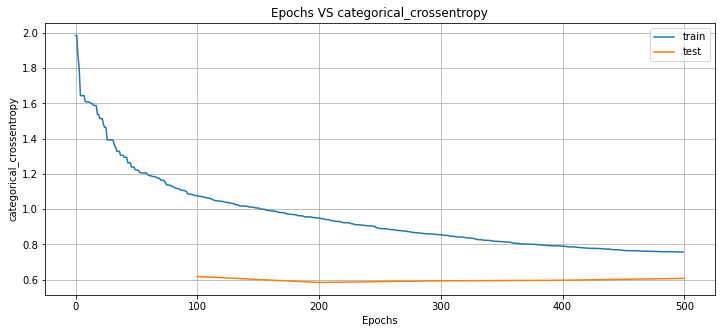

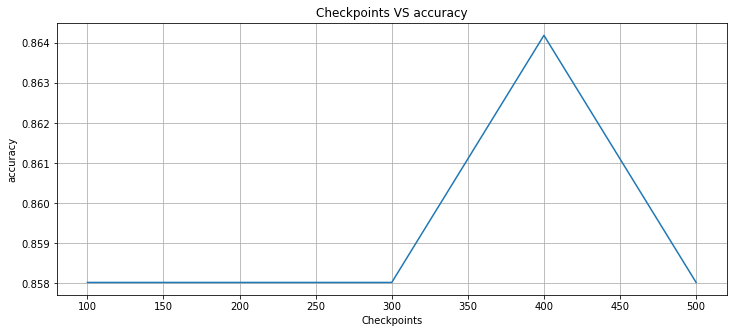

In [12]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8580246913580247, 'mean_square_error': 2.6884014930650175, 'categorical_crossentropy': 0.617634031507704, 'precision': 0.7870370370370371, 'recall': 0.7870370370370371, 'f1': 0.7870370370370371, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 12, 'tn_hit': 16, 'fn_hit': 5}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 10, 'fp_hit': 11, 'tn_hit': 84, 'fn_hit': 3}}, 'checkpoint': 100} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 2.7583334032689466, 'categorical_crossentropy': 0.5838399463229709, 'precision': 0.7870370370370371, 'recall': 0.7870370370370371, 'f1': 0.7870370370370371, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 13, 'tn_hit': 15, 'fn_hit': 4}, 1: {'tp_hit': 2, 'fp_hit': 6, 'tn_hit': 87, 'fn_hit': 13}, 2: {'tp_hit': 7, 'fp_hit': 4, 'tn_hit': 91, 'fn_hit': 6}}, 'checkpoint': 200} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 2.7168114798541265, 'categorical_crossentropy': 0.5932190506546585, 'precision'

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[[0.186224  ]
 [0.43486753]
 [0.14686419]
 [0.23625796]
 [0.18520679]]
 bias: [-0.22093022]

Neuron 1: weights:
[[-0.17773585]
 [-0.32117203]
 [-0.24257603]
 [-0.2709103 ]
 [-0.16474587]]
 bias: [0.45860752]

Neuron 2: weights:
[[-0.28316548]
 [-0.36957175]
 [-0.08650518]
 [-0.0231189 ]
 [-0.14170384]]
 bias: [0.05354596]

Neuron 3: weights:
[[0.17960943]
 [0.10014046]
 [0.19278032]
 [0.21723296]
 [0.23273413]]
 bias: [-0.0699869]

$
Layer 2
Neuron 0: weights:
[[-0.70790756]
 [ 1.2191964 ]
 [ 0.6400941 ]
 [-0.33989757]]
 bias: [0.5881466]

Neuron 1: weights:
[[ 0.619136  ]
 [-0.12589364]
 [ 0.06100597]
 [ 0.15191217]]
 bias: [-0.30373016]

Neuron 2: weights:
[[ 0.28476503]
 [-0.6617948 ]
 [-0.36599252]
 [ 0.2378833 ]]
 bias: [0.07781659]

$

